# Projet tutoré : Classification et priorisation des évènements de sécurité par les méthodes de Machine Learning

## Présenté par : Konan Guillaume David, Kouamé Esdras et Kouakou Marcel Junior

# Analyse Exploratoire des données

In [167]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import (f1_score, precision_score, recall_score,
                             roc_auc_score, confusion_matrix, roc_curve)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [144]:
df = pd.read_excel("Labelisation_Alert_EDR_v3 (1).xlsx", index_col=0)
df.head()

,alert_severity,alert_type,childproc_count,comms_ip,created_time,crossproc_count,description,feed_id,feed_name,feed_rating,...,sensor_criticality,sensor_id,sha256,status,total_hosts,unique_id,watchlist_id,watchlist_name,labelisation,incident
0,67.5,watchlist.hit.ingress.process,3,172.16.102.171,2020-07-09T17:49:13.759Z,0,Malicious Host,18,alienvault,3.0,...,3.0,3592,1ca502b1daa3d572897bbbac54ab3981318b79fe49aa33...,Unresolved,1572,60ce7e1f-f1c3-4913-8320-ce397abb18f8,malicioushost,malicioushost,True,0
1,67.5,watchlist.hit.ingress.process,3,172.16.102.171,2020-07-09T17:49:22.260Z,0,Malicious Host,18,alienvault,3.0,...,3.0,3592,1ca502b1daa3d572897bbbac54ab3981318b79fe49aa33...,Unresolved,1572,ea3dc49c-1db7-4746-a672-fbc87d396651,malicioushost,malicioushost,True,0
2,67.5,watchlist.hit.ingress.process,1,172.16.102.191,2020-07-09T18:16:39.523Z,6,Malicious Host,18,alienvault,3.0,...,3.0,2736,8785576b8190f7712b0638e931216c9c2f46d7c065908f...,Unresolved,1572,3be521e2-abf5-4ffa-b3f9-ab4770742aa7,malicioushost,malicioushost,True,0
3,67.5,watchlist.hit.ingress.process,1,172.16.102.191,2020-07-09T18:16:44.639Z,7,Malicious Host,18,alienvault,3.0,...,3.0,2736,8785576b8190f7712b0638e931216c9c2f46d7c065908f...,Unresolved,1572,20d0acb8-1451-4e18-aebb-3a54c651f4ca,malicioushost,malicioushost,True,0
4,67.5,watchlist.hit.ingress.process,3,172.16.102.171,2020-07-09T17:48:41.054Z,0,Malicious Host,18,alienvault,3.0,...,3.0,3592,1ca502b1daa3d572897bbbac54ab3981318b79fe49aa33...,Unresolved,1572,57d4d27f-b6db-4778-8e17-710411344e2c,malicioushost,malicioushost,True,0


### Nous supprimons les colonnes

In [147]:
g_df = df
df = df.drop(["feed_id", "segment_id", "process_id", "unique_id", "watchlist_id", "incident", "total_hosts", "sha256", "link", "comms_ip"], axis=1)
df.describe()

,alert_severity,childproc_count,crossproc_count,feed_rating,filemod_count,ioc_confidence,modload_count,netconn_count,regmod_count,report_score,sensor_criticality,sensor_id
count,1000.0,1000.000000,1000.000000,1000.0,1000.000000,1000.0,1000.000000,1000.000000,1000.000000,1000.0,1000.0,1000.000000
mean,67.5,4.105000,11.089000,3.0,10744.227000,0.5,165.495000,17044.834000,591.935000,100.0,3.0,2703.672000
std,0.0,12.495283,39.108369,0.0,63605.805547,0.0,122.531628,25417.243623,1667.134664,0.0,0.0,1002.962536
min,67.5,0.000000,0.000000,3.0,0.000000,0.5,30.000000,0.000000,0.000000,100.0,3.0,266.000000
25%,67.5,0.000000,0.000000,3.0,50.000000,0.5,110.000000,1018.250000,0.000000,100.0,3.0,1272.000000
50%,67.5,0.000000,5.000000,3.0,159.000000,0.5,118.000000,12437.000000,4.000000,100.0,3.0,3328.000000
75%,67.5,3.000000,6.000000,3.0,805.000000,0.5,160.250000,25598.000000,14.000000,100.0,3.0,3328.000000
max,67.5,195.000000,629.000000,3.0,907947.000000,0.5,842.000000,187015.000000,14804.000000,100.0,3.0,4132.000000


### Visualisation du déséquilibre

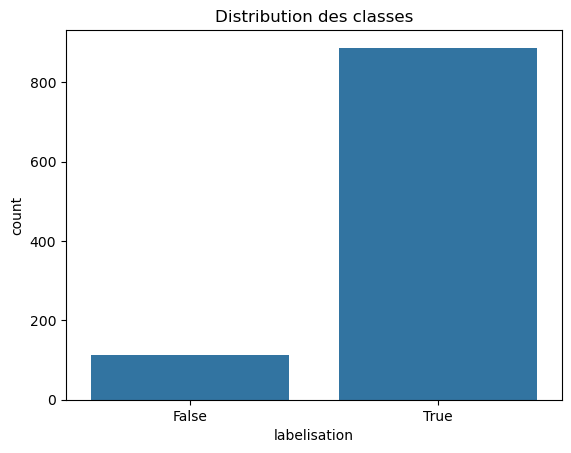

In [150]:
sns.countplot(x="labelisation", data=df)
plt.title("Distribution des classes")
plt.show()

### Corrélation avec la variable labelisation

In [153]:
corr = df.corr(numeric_only=True)["labelisation"].sort_values(ascending=False)
print(corr)

labelisation          1.000000
sensor_id             0.424184
netconn_count         0.223446
regmod_count          0.097001
modload_count        -0.144895
filemod_count        -0.444186
crossproc_count      -0.506652
childproc_count      -0.521792
alert_severity             NaN
feed_rating                NaN
ioc_confidence             NaN
report_ignored             NaN
report_score               NaN
sensor_criticality         NaN
Name: labelisation, dtype: float64


### Heatmap

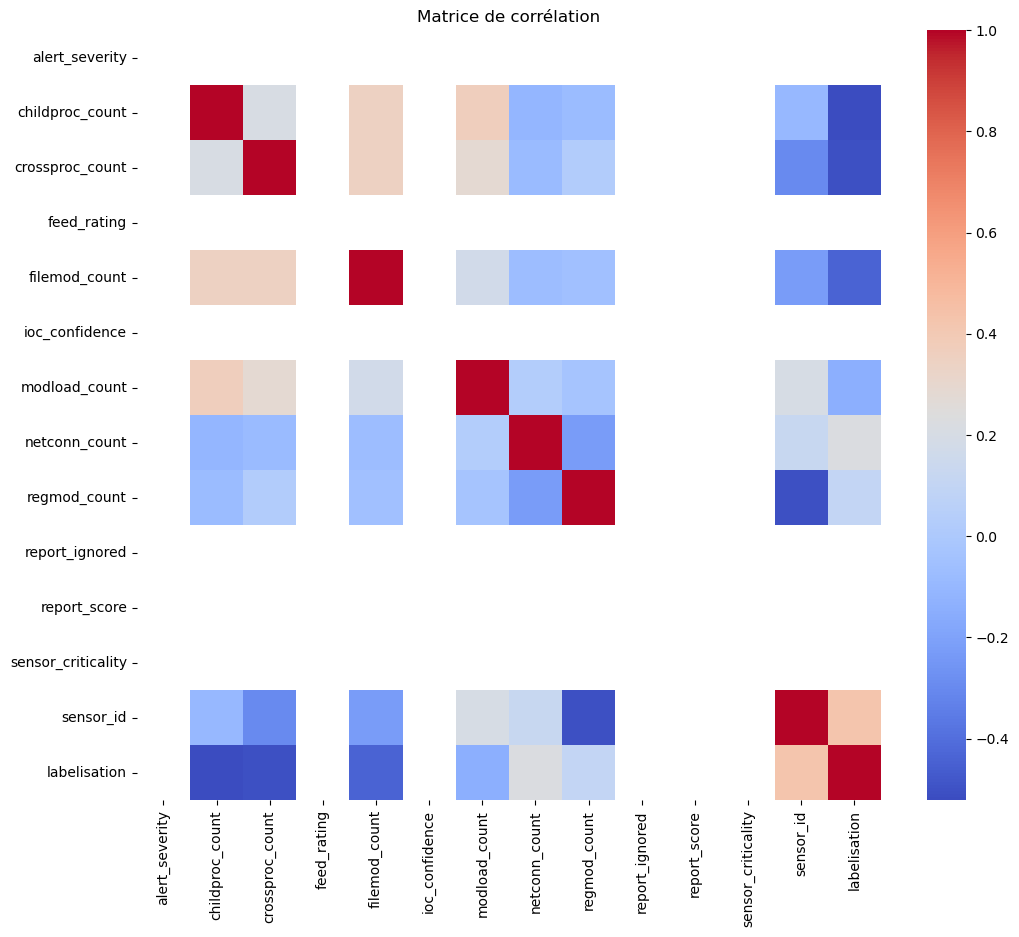

In [156]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", annot=False)
plt.title("Matrice de corrélation")
plt.show()

### Une Mise à l'échelle est necessaire, suréchantillonnage avec SMOTE


Évaluation du modèle : Random Forest
F1-score     : 1.000
Précision    : 1.000
Recall       : 1.000
AUC-ROC      : 1.000
Matrice de confusion :
[[ 23   0]
 [  0 177]]

Évaluation du modèle : XGBoost


D:\Doc_d\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:18:06] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


F1-score     : 1.000
Précision    : 1.000
Recall       : 1.000
AUC-ROC      : 1.000
Matrice de confusion :
[[ 23   0]
 [  0 177]]


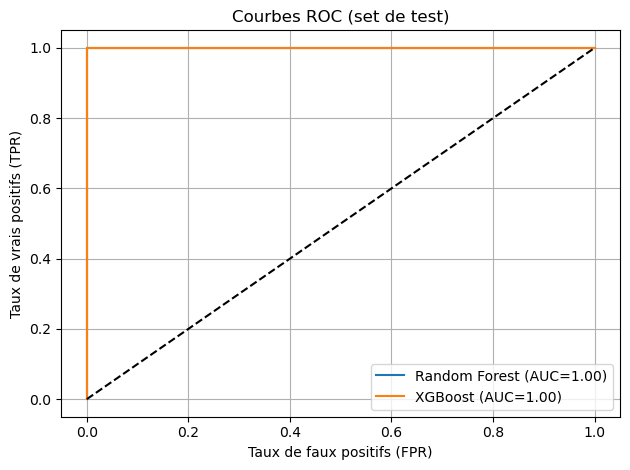

In [177]:
y = df["labelisation"]
X = df.drop(columns='labelisation')

# Encoder les variables catégorielles
for col in X.select_dtypes(include=['object', 'category']).columns:
    X[col] = X[col].astype(str)
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Séparation en données d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Modèles à tester
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=200,
        subsample=0.8,
        colsample_bytree=0.8,
        learning_rate=0.05,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
}

# Évaluation
for name, model in models.items():
    print(f"\nÉvaluation du modèle : {name}")

    pipeline = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('clf', model)
    ])

    # Entraînement sur le training set
    pipeline.fit(X_train, y_train)

    # Prédictions sur le test set
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    # Métriques
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)

    print(f"F1-score     : {f1:.3f}")
    print(f"Précision    : {precision:.3f}")
    print(f"Recall       : {recall:.3f}")
    print(f"AUC-ROC      : {auc:.3f}")
    print(f"Matrice de confusion :\n{cm}")

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc:.2f})')

# Affichage de la courbe ROC
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title("Courbes ROC (set de test)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()